In [2]:
import json
import numpy as np
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
from scipy.spatial import ConvexHull
from numpy import *

In [3]:
with open('bbox_3d.json') as json_file:
    itemData = json.load(json_file)
itemData[]
np.array(itemData[0]["boxes_3d"][0])-np.array(itemData[5]["boxes_3d"][0])

array([-0.15850592, -0.01596689,  0.25460434,  0.41596651, -0.03949976,
        0.09378743,  0.03014982])

In [4]:
def polygon_clip(subjectPolygon, clipPolygon):
   """ Clip a polygon with another polygon.

   Ref: https://rosettacode.org/wiki/Sutherland-Hodgman_polygon_clipping#Python

   Args:
     subjectPolygon: a list of (x,y) 2d points, any polygon.
     clipPolygon: a list of (x,y) 2d points, has to be *convex*
   Note:
     **points have to be counter-clockwise ordered**

   Return:
     a list of (x,y) vertex point for the intersection polygon.
   """
   def inside(p):
      return(cp2[0]-cp1[0])*(p[1]-cp1[1]) > (cp2[1]-cp1[1])*(p[0]-cp1[0])
 
   def computeIntersection():
      dc = [ cp1[0] - cp2[0], cp1[1] - cp2[1] ]
      dp = [ s[0] - e[0], s[1] - e[1] ]
      n1 = cp1[0] * cp2[1] - cp1[1] * cp2[0]
      n2 = s[0] * e[1] - s[1] * e[0] 
      n3 = 1.0 / (dc[0] * dp[1] - dc[1] * dp[0])
      return [(n1*dp[0] - n2*dc[0]) * n3, (n1*dp[1] - n2*dc[1]) * n3]
 
   outputList = subjectPolygon
   cp1 = clipPolygon[-1]
 
   for clipVertex in clipPolygon:
      cp2 = clipVertex
      inputList = outputList
      outputList = []
      s = inputList[-1]
 
      for subjectVertex in inputList:
         e = subjectVertex
         if inside(e):
            if not inside(s):
               outputList.append(computeIntersection())
            outputList.append(e)
         elif inside(s):
            outputList.append(computeIntersection())
         s = e
      cp1 = cp2
      if len(outputList) == 0:
          return None
   return(outputList)

def poly_area(x,y):
    """ Ref: http://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates """
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

def convex_hull_intersection(p1, p2):
    """ Compute area of two convex hull's intersection area.
        p1,p2 are a list of (x,y) tuples of hull vertices.
        return a list of (x,y) for the intersection and its volume
    """
    inter_p = polygon_clip(p1,p2)
    if inter_p is not None:
        hull_inter = ConvexHull(inter_p)
        return inter_p, hull_inter.volume
    else:
        return None, 0.0  

def box3d_vol(corners):
    ''' corners: (8,3) no assumption on axis direction '''
    a = np.sqrt(np.sum((corners[0,:] - corners[1,:])**2))
    b = np.sqrt(np.sum((corners[1,:] - corners[2,:])**2))
    c = np.sqrt(np.sum((corners[0,:] - corners[4,:])**2))
    return a*b*c

def is_clockwise(p):
    x = p[:,0]
    y = p[:,1]
    return np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)) > 0

def box3d_iou(corners1, corners2):
    ''' Compute 3D bounding box IoU.

    Input:
        corners1: numpy array (8,3), assume up direction is negative Y
        corners2: numpy array (8,3), assume up direction is negative Y
    Output:
        iou: 3D bounding box IoU
        iou_2d: bird's eye view 2D bounding box IoU

    todo (kent): add more description on corner points' orders.
    '''
    # corner points are in counter clockwise order
    rect1 = [(corners1[i,0], corners1[i,2]) for i in range(3,-1,-1)]
    rect2 = [(corners2[i,0], corners2[i,2]) for i in range(3,-1,-1)] 
    
    area1 = poly_area(np.array(rect1)[:,0], np.array(rect1)[:,1])
    area2 = poly_area(np.array(rect2)[:,0], np.array(rect2)[:,1])
   
    inter, inter_area = convex_hull_intersection(rect1, rect2)
    iou_2d = inter_area/(area1+area2-inter_area)
    ymax = min(corners1[0,1], corners2[0,1])
    ymin = max(corners1[4,1], corners2[4,1])

    inter_vol = inter_area * max(0.0, ymax-ymin)
    
    vol1 = box3d_vol(corners1)
    vol2 = box3d_vol(corners2)
    iou = inter_vol / (vol1 + vol2 - inter_vol)
    return iou, iou_2d

# ----------------------------------
# Helper functions for evaluation
# ----------------------------------

def get_3d_box(box_size, heading_angle, center):
    ''' Calculate 3D bounding box corners from its parameterization.

    Input:
        box_size: tuple of (length,wide,height)
        heading_angle: rad scalar, clockwise from pos x axis
        center: tuple of (x,y,z)
    Output:
        corners_3d: numpy array of shape (8,3) for 3D box cornders
    '''
    def roty(t):
        c = np.cos(t)
        s = np.sin(t)
        return np.array([[c,  0,  s],
                         [0,  1,  0],
                         [-s, 0,  c]])

    R = roty(heading_angle)
    l,w,h = box_size
    x_corners = [l/2,l/2,-l/2,-l/2,l/2,l/2,-l/2,-l/2];
    y_corners = [h/2,h/2,h/2,h/2,-h/2,-h/2,-h/2,-h/2];
    z_corners = [w/2,-w/2,-w/2,w/2,w/2,-w/2,-w/2,w/2];
    corners_3d = np.dot(R, np.vstack([x_corners,y_corners,z_corners]))
    corners_3d[0,:] = corners_3d[0,:] + center[0];
    corners_3d[1,:] = corners_3d[1,:] + center[1];
    corners_3d[2,:] = corners_3d[2,:] + center[2];
    corners_3d = np.transpose(corners_3d)
    return corners_3d

In [5]:
from filterpy.kalman import KalmanFilter


class KalmanBox3DTracker(object):
    """
    This class represents the internel state of individual tracked objects
    observed as bbox.
    """
    count = 0

    def __init__(self, bbox3D, info=False):
        """
        Initialises a tracker using initial bounding box.
        """
        # define constant velocity model
        # coord3d - array of detections [x,y,z,theta,l,w,h]
        # X,Y,Z,theta, l, w, h, dX, dY, dZ
        self.kf = KalmanFilter(dim_x=10, dim_z=7)
        self.kf.F = np.array([
            [1, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # state transition matrix
            [0, 1, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 1],
            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
        ])

        self.kf.H = np.array([
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],  # measurement function,
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
        ])

        # state uncertainty, give high uncertainty to
        self.kf.P[7:, 7:] *= 1000.
        # the unobservable initial velocities, covariance matrix
        self.kf.P *= 10.

        # self.kf.Q[-1,-1] *= 0.01    # process uncertainty
        self.kf.Q[7:, 7:] *= 0.01
        self.kf.x[:7] = bbox3D.reshape((7, 1))

        self.time_since_update = 0
        self.id = KalmanBox3DTracker.count
        KalmanBox3DTracker.count += 1
        self.nfr = 5
        self.history = []
        self.prev_ref = bbox3D
        self.hits = 1  # number of total hits including the first detection
        self.hit_streak = 1  # number of continuing hit considering the first
        # detection
        self.age = 0
        self.info = info  # other info

    @property
    def obj_state(self):
        return self.kf.x.flatten()

    def _update_history(self, bbox3D):
        self.history = self.history[1:] + [bbox3D - self.prev_ref]

    def _init_history(self, bbox3D):
        self.history = [bbox3D - self.prev_ref] * self.nfr

    def update(self, bbox3D, info=False):
        """
        Updates the state vector with observed bbox.
        """
        self.hits += 1
        self.hit_streak += 1  # number of continuing hit
        self.time_since_update = 0

        # orientation correction
        if self.kf.x[3] >= np.pi:
            self.kf.x[3] -= np.pi * 2  # make the theta still in the range
        if self.kf.x[3] < -np.pi:
            self.kf.x[3] += np.pi * 2

        new_theta = bbox3D[3]
        if new_theta >= np.pi:
            new_theta -= np.pi * 2  # make the theta still in the range
        if new_theta < -np.pi:
            new_theta += np.pi * 2
        bbox3D[3] = new_theta

        predicted_theta = self.kf.x[3]
        # if the angle of two theta is not acute angle
        if np.pi / 2.0 < abs(new_theta - predicted_theta) < np.pi * 3 / 2.0:
            self.kf.x[3] += np.pi
            if self.kf.x[3] > np.pi:
                self.kf.x[3] -= np.pi * 2  # make the theta still in the range
            if self.kf.x[3] < -np.pi:
                self.kf.x[3] += np.pi * 2

        # now the angle is acute: < 90 or > 270, convert the case of > 270 to
        # < 90
        if abs(new_theta - self.kf.x[3]) >= np.pi * 3 / 2.0:
            if new_theta > 0:
                self.kf.x[3] += np.pi * 2
            else:
                self.kf.x[3] -= np.pi * 2

        # Update the bbox3D
        self.kf.update(bbox3D)

        if self.kf.x[3] >= np.pi:
            self.kf.x[3] -= np.pi * 2  # make the theta still in the range
        if self.kf.x[3] < -np.pi:
            self.kf.x[3] += np.pi * 2
        self.info = info
        self.prev_ref = self.kf.x.flatten()[:7]

    def predict(self, update_state: bool = True):
        """
        Advances the state vector and returns the predicted bounding box
        estimate.
        """
        self.kf.predict()
        if self.kf.x[3] >= np.pi: self.kf.x[3] -= np.pi * 2
        if self.kf.x[3] < -np.pi: self.kf.x[3] += np.pi * 2

        self.age += 1
        if self.time_since_update > 0:
            self.hit_streak = 0
        self.time_since_update += 1
        return self.kf.x.flatten()

    def get_state(self):
        """
        Returns the current bounding box estimate.
        """
        return self.kf.x.flatten()

    def get_history(self):
        """
        Returns the history of estimates.
        """
        return self.history




In [6]:

class TrackletManager:
    def __init__(self):
        self.tracklets = []
    def plot_bounding_boxes(self,boxes,color):
        # Create a figure and a 3D axis
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Define colors for the bounding boxes
        colors = [color] * len(boxes)

        # Loop over the bounding boxes and their respective colors
        for vertices, color in zip(boxes, colors):
            # Extract x, y, and z coordinates
            x = vertices[:, 0]
            y = vertices[:, 1]
            z = vertices[:, 2]

            # Plot the corners as scatter points
            ax.scatter(x, y, z, c=color, marker='o')

            # Define the faces of the bounding box
            faces = np.array([
                [0, 1, 2, 3],  # Bottom face
                [4, 5, 6, 7],  # Top face
                [0, 1, 5, 4],  # Side face 1
                [1, 2, 6, 5],  # Side face 2
                [2, 3, 7, 6],  # Side face 3
                [3, 0, 4, 7]   # Side face 4
            ])

            # Create a Poly3DCollection object and add it to the plot
            collection = Poly3DCollection(vertices[faces])
            collection.set_alpha(0.2)  # Set the transparency of the bounding box
            collection.set_facecolor(color)  # Set the color of the bounding box
            ax.add_collection3d(collection)

            # Define the lines of the bounding box
            lines = [
                [vertices[0], vertices[1]],
                [vertices[1], vertices[2]],
                [vertices[2], vertices[3]],
                [vertices[3], vertices[0]],
                [vertices[4], vertices[5]],
                [vertices[5], vertices[6]],
                [vertices[6], vertices[7]],
                [vertices[7], vertices[4]],
                [vertices[0], vertices[4]],
                [vertices[1], vertices[5]],
                [vertices[2], vertices[6]],
                [vertices[3], vertices[7]]
            ]

            # Create a Line3DCollection object and add it to the plot
            lines_collection = Line3DCollection(lines, colors=color)
            ax.add_collection(lines_collection)

        # Set labels and title
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        ax.set_title('Bounding Boxes')

        # Set axis limits if needed
        # ax.set_xlim([xmin, xmax])
        # ax.set_ylim([ymin, ymax])
        # ax.set_zlim([zmin, zmax])

        # Show the plot
        plt.axis('scaled')

        ax.view_init(-70,-70,-20)
        #plt.show()


    def compute_iou_matrix(self,detections_t, detections_tplus1):
        num_detections_t = len(detections_t)
        num_detections_tplus1 = len(detections_tplus1)

        iou_matrix = np.zeros((num_detections_t, num_detections_tplus1))

        for i in range(num_detections_t):
            x1, y1, z1, w1, l1, h1, theta1 = detections_t[i]
            corners_3d_box1  = get_3d_box((w1, l1, h1), theta1, (x1, y1, z1))
        
            for j in range(num_detections_tplus1):
                x2, y2, z2, w2, l2, h2, theta2 = detections_tplus1[j]
                corners_3d_box2 = get_3d_box((w2, l2, h2), theta2, (x2, y2, z2))
                # self.plot_bounding_boxes([corners_3d_box1,corners_3d_box2])
                iou_matrix[i, j], _ = box3d_iou(corners_3d_box1,corners_3d_box2)

        return iou_matrix
    def tracklets_detections(self, tracklets, current_detections, row_indices, col_indices, iou_matrix, threshold):
        cost_matrix = 1 - iou_matrix

        associations = list(zip(row_indices, col_indices))
        indexes_to_delete = []
        for association in associations:
            tracklet_id = association[0]
            associated_detection_id = association[1]
            if cost_matrix[tracklet_id][associated_detection_id] > threshold:
                tracklets[tracklet_id]["3d_boxes"] = (current_detections[associated_detection_id])
                tracklets[tracklet_id]["Timeout"] = 0
            else :
                indexes_to_delete.append(tracklet_id)
        for index in sorted(indexes_to_delete, reverse=True):     
            del tracklets[index]
        
        indexes_to_delete = []
        for index, element in enumerate(tracklets):
            element["Timeout"] += 1
            if element["Timeout"] > 10:
                indexes_to_delete.append(index)
        for index in sorted(indexes_to_delete, reverse=True):  
            del tracklets[index]

        for detection_id in list(set(range(len(new_detections))) - set(col_indices)): 
            print("new tracklet",detection_id)
            tracklets.append({"3d_boxes":new_detections[detection_id],"Timeout":0})
        
        for tracklet in tracklets:
            if len(tracklet['3d_boxes']) > 10:
        
                tracklet["3d_boxes"] = tracklet["3d_boxes"][-10:]
        return tracklets

    def perform_hungarian_algorithm(self,iou_matrix):
        # Invert the IOU matrix to convert it to a cost matrix
        cost_matrix = 1 - iou_matrix
        # print(cost_matrix)

        # Solve the assignment problem using the Hungarian Algorithm
        row_indices, col_indices = linear_sum_assignment(cost_matrix)

        return row_indices, col_indices

    def get_last_tracklets(self):
        last_tracklets = []
        for tracklet in self.tracklets:
            last_tracklets.append(tracklet["3d_boxes"])
        return last_tracklets
    def update_tracklets(self,new_detections):


        # COMPUTE IOU MATRIX BETWEEN CURRENT TRACKLETS AND NEW DETECTIONS
        last_tracklets_box = self.get_last_tracklets()
        if last_tracklets_box == []:
            for detection in new_detections:
                self.tracklets.append({"3d_boxes":detection,"Timeout":0,"Kalman":KalmanBox3DTracker(np.array(detection))})
            return self.tracklets
        
        iou_matrix = self.compute_iou_matrix(last_tracklets_box,new_detections)
        row_indices, col_indices = self.perform_hungarian_algorithm(iou_matrix)

        current_tracklets_dict_list = self.tracklets_detections(self.tracklets, new_detections, row_indices, col_indices, iou_matrix, threshold=0.2)
        return self.tracklets
    def predict_and_update_kalman(self):
        results=[]
        for tracklet in self.tracklets:
            tracklet['Kalman'].predict()
            tracklet['Kalman'].update(tracklet['3d_boxes'])
            results.append(tracklet['Kalman'].get_state()[:6])
        return results


trackletmanager = TrackletManager()
boxes = []
refined_frames = []
for frame in itemData[0:10]:
    new_detections = list(frame['boxes_3d']).copy()
    # print(new_detections)

    # for detection in new_detections:   
    #     x1, y1, z1, w1, h1, l1, theta1 = detection
    #     boxes.append(get_3d_box((w1, l1, h1), theta1, (x1, y1, z1)))
    # print(len(boxes))
    # trackletmanager.plot_bounding_boxes(boxes,'b')
    tracketls = trackletmanager.update_tracklets(new_detections)
    refined_frame = trackletmanager.predict_and_update_kalman()
    refined_frames.append(refined_frame)
    # print((tracketls))
    # print(len(tracketls[0]['3d_boxes']))


In [18]:
from utils.visualizer import Visualizer
visualizer = Visualizer(dataset, vis_format=vis_results)

visualizer.export_as_video(args.save_dir, plot_items=['3d','2d','bev'], fps=args.fps)

[[1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1.]]


UnboundLocalError: local variable 'current_tracklets_dict_list' referenced before assignment

In [5]:
### ALTERNATIVE CODE FROM : https://github.com/AlienCat-K/3D-IoU-Python/blob/master/3D-IoU-Python.py

# 3D IoU caculate code for 3D object detection 
# Kent 2018/12

import numpy as np
from scipy.spatial import ConvexHull
from numpy import *




# ----------------------------------
# Helper functions for evaluation
# ----------------------------------


    


In [6]:
print('------------------')
# get_3d_box(box_size, heading_angle, center)

x1, y1, z1, w1, h1, l1, theta1 = itemData[0]["boxes_3d"][-1]

x2, y2, z2, w2, h2, l2, theta2 = itemData[1]["boxes_3d"][-1]

corners_3d_box1  = get_3d_box((l1, w1, h1), theta1, (x1, y1, z1)) 
corners_3d_box2 = get_3d_box((l2, w2, h2), theta2, (x2, y2, z2))


(IOU_3d,IOU_2d)=box3d_iou(corners_3d_box1,corners_3d_box2)
print (IOU_3d,IOU_2d) #3d IoU/ 2d IoU of BEV(bird eye's view)

------------------
0.10809978762440535 0.11109720832133732


-1.5819451808929443
-1.570481777191162
[array([[ 2.14627754,  1.73486698, 11.54698229],
       [ 3.59468839,  1.73486698, 11.56313108],
       [ 3.6369027 ,  1.73486698,  7.77686262],
       [ 2.18849185,  1.73486698,  7.76071383],
       [ 2.14627754,  0.14201248, 11.54698229],
       [ 3.59468839,  0.14201248, 11.56313108],
       [ 3.6369027 ,  0.14201248,  7.77686262],
       [ 2.18849185,  0.14201248,  7.76071383]]), array([[ 2.16093174,  1.7365768 , 10.57029274],
       [ 3.60638626,  1.7365768 , 10.56983807],
       [ 3.60520872,  1.7365768 ,  6.82627174],
       [ 2.1597542 ,  1.7365768 ,  6.82672641],
       [ 2.16093174,  0.14552999, 10.57029274],
       [ 3.60638626,  0.14552999, 10.56983807],
       [ 3.60520872,  0.14552999,  6.82627174],
       [ 2.1597542 ,  0.14552999,  6.82672641]])]


NotImplementedError: Axes3D currently only supports the aspect argument 'auto'. You passed in 'equal'.

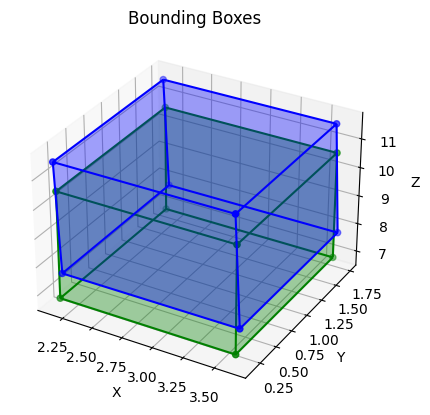

In [8]:
import numpy as np

# Example usage with two bounding boxes

x1, y1, z1, w1, l1, h1, theta1 = itemData[1]["boxes_3d"][0]

x2, y2, z2, w2, l2, h2, theta2 = itemData[2]["boxes_3d"][0]

box1  = get_3d_box((w1, l1, h1), theta1, (x1, y1, z1)) 
box2 = get_3d_box((w2, l2, h2), theta2, (x2, y2, z2))
print(theta1)
print(theta2)
# Combine the two bounding boxes
boxes = [box1, box2]
print(boxes)
# Plot the bounding boxes with different colors
plot_bounding_boxes(boxes)



In [ ]:
class Tracking(object):

    def __init__(self, bbox3D, info):

        self.current_tracklet_dict_list = []


    def _update_history(self, bbox3D):
        self.history = self.history[1:] + [bbox3D - self.prev_ref]

In [91]:
detections = np.copy(itemData[0]["boxes_3d"])
print(detections)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (9, 8) + inhomogeneous part.

In [50]:
import numpy as np
from scipy.linalg import block_diag

def kalman_filter(previous_boxes, detections, association_results):
    # Kalman filter parameters
    dt = 1.0  # Time step
    A = np.array([
        [1, 0, 0, dt, 0, 0],
        [0, 1, 0, 0, dt, 0],
        [0, 0, 1, 0, 0, dt],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ])
    H = np.array([
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0]
    ])
    Q = block_diag(np.eye(3) * 0.1, np.eye(3) * 0.01)
    R = np.eye(3) * 0.1

    state = np.zeros(6)
    covariance = np.eye(6)

    predicted_boxes = []

    for association in association_results:
        previous_index, detection_index = association
        previous_coordinates = previous_boxes[previous_index]
        x, y, z = previous_coordinates[:3]
        state[:3] = [x, y, z]

        state = A.dot(state)
        covariance = A.dot(covariance).dot(A.T) + Q

        detection = detections[detection_index]
        measurement = detection[:3]

        residual = measurement - H.dot(state)
        residual_covariance = H.dot(covariance).dot(H.T) + R
        kalman_gain = covariance.dot(H.T).dot(np.linalg.inv(residual_covariance))

        state += kalman_gain.dot(residual)
        covariance = (np.eye(6) - kalman_gain.dot(H)).dot(covariance)

        predicted_coordinates = state[:3]
        predicted_boxes.append(predicted_coordinates)

    return predicted_boxes

# Example usage

previous_boxes = itemData[0]["boxes_3d"]
detections = itemData[1]["boxes_3d"]

iou_matrix = compute_iou_matrix(previous_boxes, detections)
row_indices, col_indices = perform_hungarian_algorithm(iou_matrix)
associations = associate_detections(iou_matrix, threshold=0.1)

print("Associations:", associations)

# Example usage

# previous_boxes = [[0, 0, 0, 2, 2, 2, 0], [0, 0, 0, 2, 2, 2, 0]]
# detections = [[3, 3, 3, 2, 2, 2, 0], [3, 3, 3, 2, 2, 2, 0]]
# associations = [(0, 0), (1,1)]

# Predict the next bounding boxes using Kalman filter
predicted_boxes = kalman_filter(previous_boxes, detections, associations)

print("Predicted Boxes:")
for box in predicted_boxes:
    print(box)


9
[[0.57151511 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.52420831 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.43143368 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.45629743 0.         0.
  0.         0.02783226 0.        ]
 [0.         0.         0.         0.         0.57048681 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.27283976
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.4487557  0.         0.15721575]
 [0.         0.         0.         0.         0.         0.
  0.         0.21657867 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.47279161]]
Associations: [(0, 0), (1, 2), (2, 1), (3, 3), (4, 4), (5, 5), (6, 6), (6, 8), (7, 7), (8, 8)]
Predicted Boxes:
[-4.35000038 

In [23]:
!pip install filterpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110459 sha256=2f366517d561b2c84e3a1483b7f98f1c109a579525cc2d0002cdf97f10354497
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [35]:
import numpy as np
from scipy.linalg import block_diag
from filterpy.kalman import KalmanFilter

def kalman_filter(associations, detections, previous_boxes):
    # Kalman filter parameters
    dt = 1.0  # Time step

    num_boxes = len(previous_boxes)
    num_detections = len(detections)
    state_dim = 10  # [x, y, z, w, h, l, roty, dx, dy, dz]

    # Initialize Kalman filter for each box
    kf = [KalmanFilter(dim_x=state_dim, dim_z=7) for _ in range(num_boxes)]
    for kf_i in kf:
        kf_i.F = np.array([
            [1, 0, 0, 0, 0, 0, 0, dt, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, dt, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, dt],
            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
        ])
        kf_i.H = np.array([
            [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
        ])
        kf_i.P[7:, 7:] *= 1000.  # state uncertainty
        kf_i.P *= 10.  # initial covariance matrix
        kf_i.Q[7:, 7:] *= 0.01  # process uncertainty

    # Perform Kalman filtering for each association
    predicted_boxes = []
    for i in range(num_boxes):
      for j in range(num_detectins):
        if 
    # for i in range(num_boxes):
    #     assoc_i = associations[i]
    #     detection_i = detections[assoc_i]
    #     prev_box_i = previous_boxes[i]

    #     # Predict step
    #     kf[i].predict()

    #     # Update step
    #     kf[i].update(detection_i)

    #     # Get the predicted state
    #     predicted_state_i = kf[i].x[:7].reshape(-1)

    #     # Combine the predicted state with previous box dimensions
    #     predicted_box_i = np.concatenate((predicted_state_i, prev_box_i[3:]))

    #     # Store the predicted box
    #     predicted_boxes.append(predicted_box_i)

    return predicted_boxes


In [37]:
# Example usage

previous_boxes = itemData[0]["boxes_3d"]
detections = itemData[1]["boxes_3d"]

iou_matrix = compute_iou_matrix(previous_boxes, detections)
row_indices, col_indices = perform_hungarian_algorithm(iou_matrix)
associations = associate_detections(iou_matrix, threshold=0.2)

print("Associations:", associations)



# Predict the next bounding box centers using Kalman filter
predicted_boxes = kalman_filter(previous_boxes, detections, associations)


9
[[0.57151511 0.         0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.52420831 0.         0.         0.
  0.         0.         0.        ]
 [0.         0.43143368 0.         0.         0.         0.
  0.         0.         0.        ]
 [0.         0.         0.         0.45629743 0.         0.
  0.         0.02783226 0.        ]
 [0.         0.         0.         0.         0.57048681 0.
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.27283976
  0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.4487557  0.         0.15721575]
 [0.         0.         0.         0.         0.         0.
  0.         0.21657867 0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.47279161]]
Associations: [(0, 0), (1, 2), (2, 1), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (8, 8)]


TypeError: ignored

In [39]:
detections[0]

[2.891590118408203,
 1.734866976737976,
 9.661922454833984,
 3.786503791809082,
 1.4485008716583252,
 1.5928544998168945,
 -1.5819451808929443]

In [40]:
import numpy as np

import torch


# TRACKER_MODEL_ZOO = {
#     'KalmanBox3DTracker': KalmanBox3DTracker,
#     'LSTM3DTracker': LSTM3DTracker,
#     'DummyTracker': DummyTracker,
# }


# def get_tracker(tracker_model_name) -> object:
#     tracker_model = TRACKER_MODEL_ZOO.get(tracker_model_name, None)
#     if tracker_model is None:
#         raise NotImplementedError

#     return tracker_model


In [32]:
bbox3d = np.array([x,y,z,theta,l,w,h])
bbox3d

array([-15.71,   2.16,  38.26,   1.57,   4.01,   1.76,   1.49])

In [ ]:
bbo

In [26]:
myKalman3DTracker = KalmanBox3DTracker(bbox3d, None)

[2.858652353286743,
 1.673215627670288,
 10.51982593536377,
 3.854074001312256,
 1.443990707397461,
 1.6053922176361084,
 -1.568232536315918]

In [27]:
# Next image :
bbox3d = 1.05 * bbox3d
bbox3d[3] = 1.57
bbox3d

AttributeError: ignored

In [ ]:
myKalman3DTracker.update(bbox3d, None)

In [ ]:
myKalman3DTracker.get_history()

In [ ]:
myKalman3DTracker.predict(True)

In [ ]:
# Next image :
bbox3d = 1.05 * bbox3d
bbox3d[3] = 1.57
bbox3d

In [ ]:
myKalman3DTracker.update(bbox3d, None)

In [ ]:
myKalman3DTracker.predict(True)

In [ ]:
myKalman3DTracker.get_history()

In [ ]:
for i in range(5):
  # Next image :
  bbox3d = 1.05 * bbox3d
  bbox3d[3] = 1.57
  myKalman3DTracker.update(bbox3d, None)
myKalman3DTracker.predict(True)

In [ ]:
myKalman3DTracker.id

In [ ]:
myKalman3DTracker.prev_ref

In [ ]:
from mpl_toolkits import mplot3d

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')